In [ ]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
def gini(y):
    counts = Counter(y)
    return 1 - sum((count / len(y)) ** 2 for count in counts.values())

# Split the dataset based on feature and threshold
def split_dataset(X, y, feature_index, threshold):
    left = X[:, feature_index] <= threshold
    right = X[:, feature_index] > threshold
    return X[left], y[left], X[right], y[right]

In [ ]:
def best_split(X, y):
    best_gini = float('inf')
    best_index = None
    best_threshold = None

    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            gini_left = gini(y_left)
            gini_right = gini(y_right)
            weighted_avg = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)

            if weighted_avg < best_gini:
                best_gini = weighted_avg
                best_index = feature_index
                best_threshold = threshold

    return best_index, best_threshold

# Node class for tree
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

In [ ]:
def build_tree(X, y, depth=0, max_depth=3):
    if len(set(y)) == 1:
        return Node(value=y[0])
    if depth >= max_depth or len(y) == 0:
        return Node(value=Counter(y).most_common(1)[0][0])

    feature_index, threshold = best_split(X, y)
    if feature_index is None:
        return Node(value=Counter(y).most_common(1)[0][0])

    X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
    left = build_tree(X_left, y_left, depth + 1, max_depth)
    right = build_tree(X_right, y_right, depth + 1, max_depth)
    return Node(feature_index, threshold, left, right)

# Prediction
def predict_single(node, x):
    while not node.is_leaf():
        if x[node.feature_index] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value


In [ ]:
def predict(node, X):
    return np.array([predict_single(node, sample) for sample in X])

# Train the tree
tree = build_tree(X_train, y_train, max_depth=3)

# Make predictions
y_pred = predict(tree, X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.93


# **Name: Swayam Chandak**

# **PRN: 12211526**

# **Roll No: CSAI-10**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
data = datasets.load_iris()
# data = pd.DataFrame(data.data, columns=data.feature_names)
# print(data.head())

X = data.data
y = data.target

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=10)



# **Decision Tree Classifier**
Theory: A Decision Tree is a non-linear supervised learning algorithm used for both classification and regression tasks. It divides the data into smaller subsets based on feature values, creating a tree-like structure where:

Nodes represent features.
Edges represent feature values.
Leaves represent the target variable’s class label or a predicted value.
In this case, the algorithm builds a tree to predict the Species of a flower based on features like SepalLengthCm, SepalWidthCm, PetalLengthCm, and PetalWidthCm.

Steps Involved:

The algorithm selects the feature that best splits the data (using metrics like Gini Impurity or Entropy) and recursively creates nodes until it reaches a stopping criterion (e.g., maximum depth or minimum samples per leaf).

In [6]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

# Check the model's performance
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")


Training Accuracy: 1.0
Testing Accuracy: 0.9523809523809523


**Cost Complexity Pruning**

Theory: Cost Complexity Pruning (also known as "Weakest Link Pruning") is a technique used to reduce overfitting in decision trees by pruning branches that provide little predictive power.

Pruning removes branches that have little importance and simplifies the model, preventing it from fitting to noise in the data. The pruning is controlled by a parameter ccp_alpha. By tuning this parameter, the tree's complexity can be controlled:

Low values of ccp_alpha result in a tree that closely fits the training data (possibly overfitting).
High values of ccp_alpha lead to a simpler tree with fewer splits (higher bias but lower variance).
Pruning helps balance the trade-off between bias and variance, leading to better generalization on unseen data.

In [ ]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

pruned_trees = []
for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    pruned_tree.fit(X_train, y_train)
    pruned_trees.append(pruned_tree)

print(pruned_trees)
test_accuracies = [tree.score(X_test, y_test) for tree in pruned_trees]
best_tree = pruned_trees[test_accuracies.index(max(test_accuracies))]

print(f"Best Pruned Tree Test Accuracy: {max(test_accuracies)}")


[DecisionTreeClassifier(ccp_alpha=np.float64(0.0), random_state=42), DecisionTreeClassifier(ccp_alpha=np.float64(0.3111111111111111),
                       random_state=42), DecisionTreeClassifier(ccp_alpha=np.float64(0.35259259259259257),
                       random_state=42)]
Best Pruned Tree Test Accuracy: 0.9809523809523809


# **Random Forest Classifier**

Theory: A Random Forest is an ensemble learning method that creates multiple decision trees and combines their results to improve performance and reduce overfitting.

Ensemble Learning: The idea is to build multiple models (here, decision trees) and combine them to get a stronger, more accurate model.

Bagging (Bootstrap Aggregating): In Random Forest, each tree is trained on a random subset of the data using bootstrapping, meaning that the data points are sampled with replacement. Each tree may be trained on different subsets, making the model robust to overfitting.

Feature Randomness: For each split in a tree, a random subset of features is considered, ensuring that the trees are decorrelated and reducing overfitting.
The predictions from all the trees are averaged for regression or voted on for classification to determine the final prediction.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

train_accuracy_rf = rf.score(X_train, y_train)
test_accuracy_rf = rf.score(X_test, y_test)

print(f"Random Forest Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf}")


Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.9904761904761905


# **AdaBoost with Decision Stumps**
Theory: AdaBoost (Adaptive Boosting) is an ensemble learning technique that combines weak learners (models that perform slightly better than random guessing, such as decision stumps) into a strong classifier.


Decision Stumps are shallow decision trees with only one split (a depth of 1). While a single decision stump is weak, AdaBoost can iteratively improve its performance by focusing on the mistakes made by previous stumps.
Boosting refers to training models sequentially, where each subsequent model focuses on the errors made by the previous ones. The algorithm assigns higher weights to misclassified data points so that the next model focuses more on correcting those errors.

Working of AdaBoost:

Initially, all data points are given equal weight.
After each weak learner (decision stump) is trained, the weights of the misclassified data points are increased, and those of correctly classified points are decreased.
A final strong model is formed by combining the weak learners.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


decision_stump = DecisionTreeClassifier(max_depth=1)

ada_boost = AdaBoostClassifier(estimator=decision_stump, n_estimators=50, random_state=42)

ada_boost.fit(X_train, y_train)

train_accuracy_ada = ada_boost.score(X_train, y_train)
test_accuracy_ada = ada_boost.score(X_test, y_test)

print(f"AdaBoost Training Accuracy: {train_accuracy_ada}")
print(f"AdaBoost Testing Accuracy: {test_accuracy_ada}")


AdaBoost Training Accuracy: 1.0
AdaBoost Testing Accuracy: 0.9809523809523809


# **Model Evaluation**
Theory: Once the models are trained, they need to be evaluated to ensure that they generalize well to unseen data. Common evaluation metrics include:

Accuracy: The ratio of correctly predicted instances to the total instances. It’s a general measure of model performance but may not be informative for imbalanced datasets.
Confusion Matrix: A table used to describe the performance of a classification model. It shows the number of true positives, false positives, true negatives, and false negatives.

Precision, Recall, F1-Score: These metrics are especially useful in imbalanced classification problems.
Precision: The ratio of true positive predictions to all positive predictions.
Recall: The ratio of true positive predictions to all actual positives.
F1-Score: The harmonic mean of precision and recall, used when you need a balance between precision and recall.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_rf = rf.predict(X_test)

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.97      1.00      0.99        36
           2       1.00      0.97      0.99        36

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105

Confusion Matrix (Random Forest):
[[33  0  0]
 [ 0 36  0]
 [ 0  1 35]]


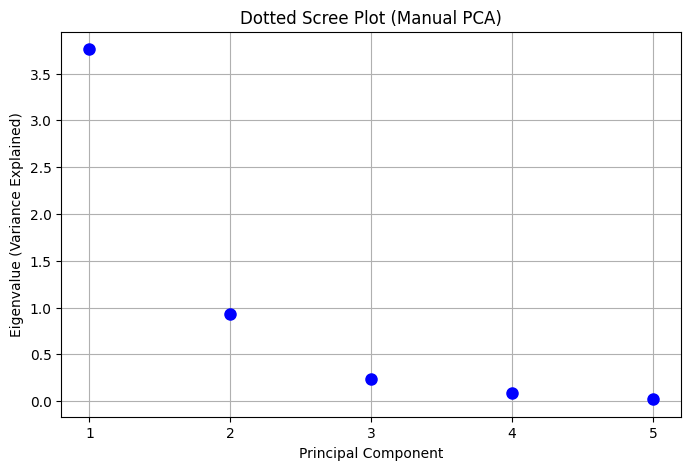

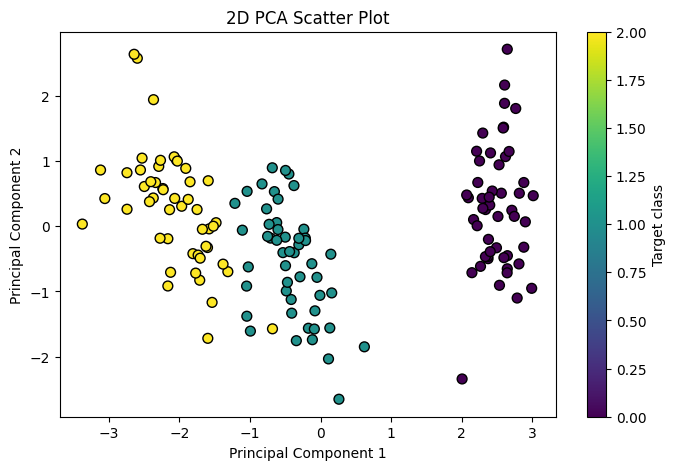

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the Iris dataset
data = pd.read_csv("Iris.csv")

# Separate features and target
X = data.drop('Species', axis=1)  # Replace 'species' with your actual target column name
y = data['Species']  # Replace 'species' with your actual target column name

# Step 1: Standardize the data
X_mean = np.mean(X, axis=0)  # Compute mean for each feature
X_std = np.std(X, axis=0)    # Compute std for each feature

X_scaled = (X - X_mean) / X_std  # Standardize the data

# Step 2: Compute the Covariance Matrix
cov_matrix = np.cov(X_scaled, rowvar=False)  # Covariance matrix (each feature is a column)

# Step 3: Eigenvalue Decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # Compute eigenvalues and eigenvectors

# Step 4: Sort Eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices that would sort the eigenvalues in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]  # Sorted eigenvalues
sorted_eigenvectors = eigenvectors[:, sorted_indices]  # Sort eigenvectors accordingly

# Step 5: Dotted Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, 'bo', markersize=8)  # 'bo' for blue dots
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Variance Explained)')
plt.title('Dotted Scree Plot (Manual PCA)')
plt.xticks(range(1, len(sorted_eigenvalues) + 1))  # Show ticks for each principal component
plt.grid(True)
plt.show()

# Step 6: Project the data onto the top 2 principal components
# Select the top 2 eigenvectors (components)
top_2_eigenvectors = sorted_eigenvectors[:, :2]

# Project the standardized data onto the top 2 principal components
X_pca = np.dot(X_scaled, top_2_eigenvectors)

# Step 7: Encode categorical labels into numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode the target labels (e.g., 'setosa', 'versicolor', 'virginica')

# Step 8: Scatter Plot of the 2D PCA representation
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', edgecolor='k', s=50)

# Adding labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Scatter Plot')

# Add a color bar to indicate the target classes
plt.colorbar(scatter, label='Target class')

plt.show()